# Get and save median data of HL60 + LatB + Noco from new experiments with measurement for strain correction

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=0.8)
from tqdm.notebook import tqdm

from scripts.stress_hyper import (shear_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  normal_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  total_stress_hyper_wc60_lc500_net_strain_ir_20240226
                                  )

In [48]:
print("numpy v{}".format(np.__version__))
import matplotlib
print("matplotlib v{}".format(matplotlib.__version__))
print("pandas v{}".format(pd.__version__))
print("seaborn v{}".format(sns.__version__))
import lmfit
print("lmfit v{}".format(lmfit.__version__))

numpy v1.25.2
matplotlib v3.7.1
pandas v2.0.3
seaborn v0.12.2
lmfit v1.2.2


Versions 20231019:
```
numpy v1.25.2
matplotlib v3.7.1
pandas v2.0.3
seaborn v0.12.2
lmfit v1.2.2
```

In [49]:
def get_df_strain_features(df_in):
    df_in['strain_inert'] = df_in['inert_ratio_raw'] - 1
    # net tensile strain based on inertia ratio assuming shape is an ellipse
    df_in['net_strain_inert'] = ((df_in['inert_ratio_raw'] - 1)
                                 / np.sqrt(df_in['inert_ratio_raw']))
    # strain features based on principal inertia ratio
    df_in['strain_inert_prnc'] = df_in['inert_ratio_prnc'] - 1
    # net tensile strain based on inertia ratio assuming shape is an ellipse
    df_in['net_strain_inert_prnc'] = ((df_in['inert_ratio_prnc'] - 1)
                                      / np.sqrt(df_in['inert_ratio_prnc']))
    df_in['taylor_strain_ir'] = ((df_in['inert_ratio_raw'] - 1)
                                 / (df_in['inert_ratio_raw'] + 1))
    # ellipse features
    df_in['net_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                               / np.sqrt(df_in['ell_major'] * df_in['ell_minor']))
    df_in['taylor_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                                  / (df_in['ell_major'] + df_in['ell_minor']))
    df_in['aspect_ell'] = df_in['ell_major'] / df_in['ell_minor']
    return df_in


In [50]:
# location of all data exports
data_exports = r"..\data_exports"

In [51]:
sample_order = ['DMSO', 'LatB', 'Noco', 'LatB+Noco']

## Read in inlet data for all measurements

In [52]:
print("Reading in data 20231010")
path_20231010_inlet = os.path.join(data_exports,
                                   "20231010_HL60_LatB_Noco",
                                   "20231010_hl60_latb_noco_inlet.tsv")
df_20231010_inlet = pd.read_csv(path_20231010_inlet, sep='\t', index_col=0)

print("Reading in data 20231012")
path_20231012_inlet = os.path.join(data_exports,
                                   "20231012_HL60_LatB_Noco",
                                   "20231012_hl60_latb_noco_inlet.tsv")
df_20231012_inlet = pd.read_csv(path_20231012_inlet, sep='\t', index_col=0)

print("Reading in data 20231019")
path_20231019_inlet = os.path.join(data_exports,
                                   "20231019_HL60_LatB_Noco",
                                   "20231019_hl60_latb_noco_inlet.tsv")
df_20231019_inlet = pd.read_csv(path_20231019_inlet, sep='\t', index_col=0)

print("Done")

Reading in data 20231010
Reading in data 20231012
Reading in data 20231019
Done


In [53]:
df_inlet_all = pd.concat([df_20231010_inlet,
                          df_20231012_inlet,
                          df_20231019_inlet
                          ], ignore_index=True)
df_inlet_all = get_df_strain_features(df_inlet_all)

##### Cut data into bins

In [54]:
x_feat = 'pos_x'
n_bins = 120
# need to iterate over all dates, concentrations
# to create bins then concatenate to big dataframe again
df_median_inlet = pd.DataFrame()
dates = df_inlet_all['date'].unique()
for date in dates:
    df_date = df_inlet_all.loc[df_inlet_all['date'] == date]
    for sample in df_date['sample'].unique():
        df_sample = df_date.loc[df_date['sample'] == sample]
        bins = pd.cut(df_sample[x_feat], n_bins)
        df_grouped = df_sample.groupby(by=['sample', bins],
                                       as_index=False
                                       )
        df_median_inlet = pd.concat([df_median_inlet, df_grouped.median()], ignore_index=True)
df_median_inlet.reset_index(inplace=True, drop=True)

Replace original sample names with more convenient description

In [55]:
df_median_inlet['sample'].replace(to_replace={'DMSO': 'DMSO',
                                              '1uM_Noco': 'Noco',
                                              '250nM_LatB': 'LatB',
                                              '250nM_LatB_1uM_Noco': 'LatB+Noco'
                                              },
                                  inplace=True)

In [56]:
df_median_inlet

sample  area_msd  area_ratio    area_um    aspect  bright_avg  bright_sd  \
0      Noco     302.0    1.050465  147.27440  1.078788  122.738065  26.889936   
1      Noco     283.5    1.045198  136.40800  1.111111  122.232140  26.643753   
2      Noco     310.5    1.047927  151.43600  1.090909  122.653390  27.194588   
3      Noco     291.0    1.046474  139.87600  1.090909  122.164650  27.462800   
4      Noco     309.5    1.052006  150.04881  1.111111  122.753930  26.282230   
...     ...       ...         ...        ...       ...         ...        ...   
1435   DMSO     277.5    1.037493  133.17120  1.000000  123.024732  23.459945   
1436   DMSO     293.5    1.039877  140.10721  1.000000  124.226190  23.036629   
1437   DMSO     275.0    1.036909  132.47760  1.000000  123.654565  23.716010   
1438   DMSO     275.0    1.039146  133.40240  1.047619  124.644670  22.910590   
1439   DMSO     257.0    1.038760  123.22961  1.043478  124.293160  23.433468   

          circ    deform  ell_angle  ...        date    wc  strain_inert  \
0     0.980715  0.019285   0.530462  ...  20231010.0  60.0      0.073848   
1     0.975902  0.024098   2.500569  ...  20231010.0  60.0      0.100725   
2     0.977378  0.022622   2.230670  ...  20231010.0  60.0      0.071382   
3     0.980092  0.019908   1.830197  ...  20231010.0  60.0      0.081189   
4     0.979465  0.020535   1.544504  ...  20231010.0  60.0      0.104976   
...        ...       ...        ...  ...         ...   ...           ...   
1435  0.986955  0.013045   1.126528  ...  20231019.0  60.0      0.021129   
1436  0.985781  0.014219   1.911862  ...  20231019.0  60.0      0.019898   
1437  0.985968  0.014032   1.448098  ...  20231019.0  60.0      0.018907   
1438  0.984991  0.015009   2.166464  ...  20231019.0  60.0      0.022584   
1439  0.985031  0.014969   1.201275  ...  20231019.0  60.0      0.013839   

      net_strain_inert  net_strain_ell  taylor_strain_ell  strain_inert_prnc  \
0             0.071263        0.117286           0.058541           0.106475   
1             0.096005        0.140053           0.069855           0.139413   
2             0.068963        0.128118           0.063928           0.126919   
3             0.078081        0.112204           0.056014           0.116172   
4             0.099865        0.127155           0.063449           0.131255   
...                ...             ...                ...                ...   
1435          0.020908        0.053113           0.026547           0.055909   
1436          0.019703        0.058729           0.029352           0.059628   
1437          0.018731        0.062563           0.031266           0.064037   
1438          0.022334        0.062807           0.031388           0.061423   
1439          0.013744        0.060617           0.030294           0.055934   

      net_strain_inert_prnc  taylor_strain_ir  aspect_ell  
0                  0.101213          0.035609    1.124405  
1                  0.130606          0.047948    1.150203  
2                  0.119558          0.034461    1.136587  
3                  0.109960          0.039011    1.118675  
4                  0.123406          0.049870    1.135496  
...                     ...               ...         ...  
1435               0.054409          0.010453    1.054542  
1436               0.057926          0.009851    1.060479  
1437               0.062081          0.009365    1.064551  
1438               0.059619          0.011166    1.064810  
1439               0.054432          0.006872    1.062482  

[1440 rows x 66 columns]

##### Fit quadratic function to net tensile strain from inertia ratio data

In [67]:
strain_feat = 'net_strain_inert'
fit_feat = 'net_strain_inert_fit'

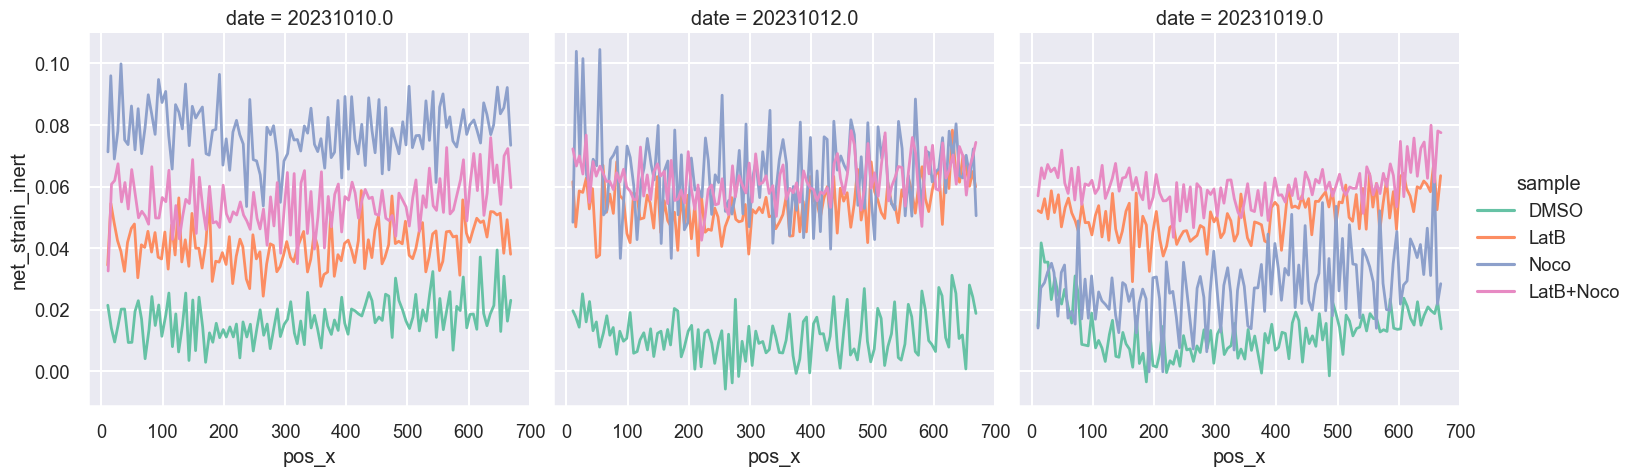

In [68]:
facet_kws = {#'xlim': [-0.04, 0.04],
    'sharex': False,
    'legend_out': True
}
g = sns.relplot(data=df_median_inlet,
                x='pos_x', y=strain_feat,
                hue='sample',hue_order=sample_order,  palette='Set2',
                col='date',
                kind='line', linewidth=2,
                facet_kws=facet_kws
                )
# g.axes[0,0].legend(ncols=2, title="[LatB] [nM]")
# g.refline(x=0, color='gray', linestyle='--', lw=1, markersize=0)
# plt.tight_layout()
plt.show()

In [69]:
net_strain_ir_polys = {}

df_median_inlet[fit_feat] = np.nan

for date in dates:
    df_date = df_median_inlet[df_median_inlet['date'] == date].copy()
    for sample in sample_order:
        idx = ((df_median_inlet['date'] == date)
               & (df_median_inlet['sample'] == sample))
        df_sample = df_median_inlet.loc[idx]
        x = df_sample['pos_x'].to_numpy()
        y = df_sample[strain_feat].to_numpy()

        # remove nans
        non_nan = ~(np.isnan(x) | np.isnan(y))
        x_nonan = x[non_nan]
        y_nonan = y[non_nan]

        model = lmfit.models.QuadraticModel()
        # use built-in default values for paras from lmfit
        paras = model.guess(y_nonan, x=x_nonan)
        result = model.fit(y_nonan, paras, x=x_nonan)

        key = f"{date}_{sample}"
        # if key == "20231019_DMSO":
        #     result.params['a'].value = 1.003379198200177e-07
        #     result.params['b'].value = -5.113443734584325e-05
        #     result.params['c'].value = 0.015
        net_strain_ir_polys[key] = result.params

        df_median_inlet[fit_feat][idx] = model.eval(result.params, x=x)

C:\Users\freiche\AppData\Local\Temp\ipykernel_3048\2971304461.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_median_inlet[fit_feat][idx] = model.eval(result.params, x=x)
C:\Users\freiche\AppData\Local\Temp\ipykernel_3048\2971304461.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_median_inlet[fit_feat][idx] = model.eval(result.params, x=x)
C:\Users\freiche\AppData\Local\Temp\ipykernel_3048\2971304461.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

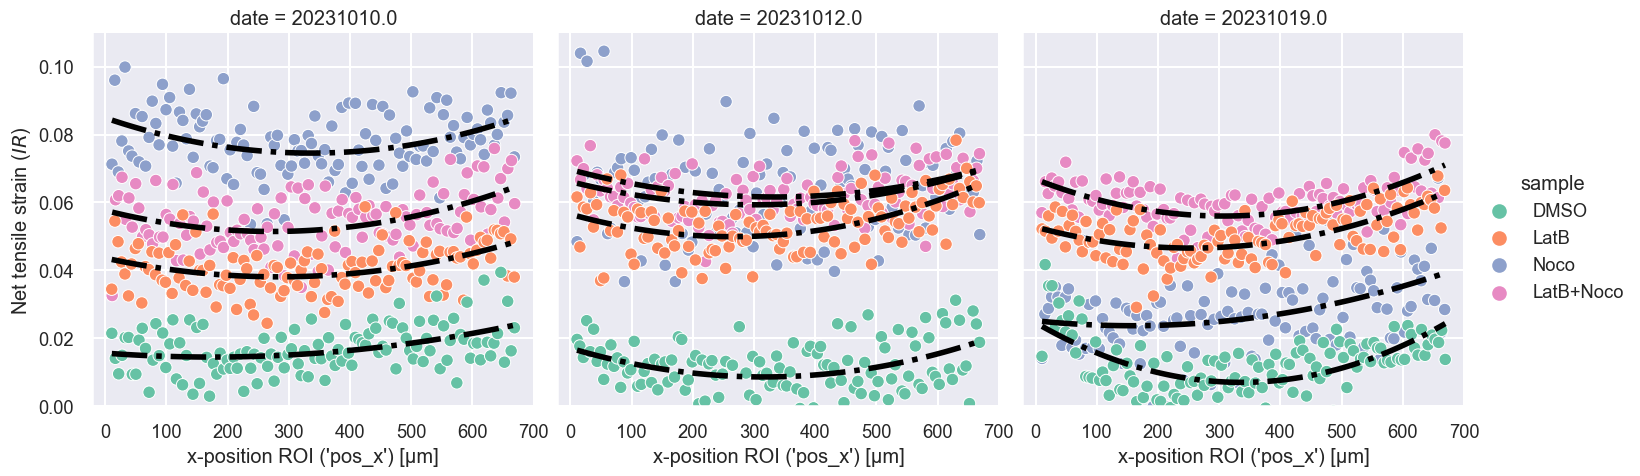

In [70]:
g = sns.relplot(data=df_median_inlet, x='pos_x', y=strain_feat,
                hue='sample', hue_order=sample_order, palette='Set2',
                col='date',
                aspect=1,
                kind='scatter',
                facet_kws={'legend_out': True})
g.set_xlabels("x-position ROI ('pos_x') [µm]")
g.set_ylabels("Net tensile strain ($IR$)")
g.axes[0,0].set_ylim(0)
# g.axes[0].legend(ncol=1, title="Sample", fontsize=12)

for ii, date in enumerate(dates):
    ax = g.axes[0, ii]
    for sample in sample_order:
        idx = (df_median_inlet['date'] == date) & (df_median_inlet['sample'] == sample)
        df = df_median_inlet.loc[idx]

        x = df['pos_x'].to_numpy()
        y = df[fit_feat].to_numpy()
        ii_sort = np.argsort(x)
        x = x[ii_sort]
        y = y[ii_sort]

        ax.plot(x, y, c='k', ls='-.', lw=4)

plt.show()

In [71]:
net_strain_ir_polys

{'20231010_DMSO': Parameters([('a', <Parameter 'a', value=3.8396993166793285e-08 +/- 1.71e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-1.3345437437610794e-05 +/- 1.2e-05, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.015607279033773465 +/- 0.00177, bounds=[-inf:inf]>)]),
 '20231010_LatB': Parameters([('a', <Parameter 'a', value=6.88051588193532e-08 +/- 1.81e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-3.8974316856537003e-05 +/- 1.27e-05, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.04359710029952156 +/- 0.00187, bounds=[-inf:inf]>)]),
 '20231010_Noco': Parameters([('a', <Parameter 'a', value=9.146071099524256e-08 +/- 2.4e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=-6.157639186309707e-05 +/- 1.68e-05, bounds=[-inf:inf]>), ('c', <Parameter 'c', value=0.0848993205238547 +/- 0.00247, bounds=[-inf:inf]>)]),
 '20231010_LatB+Noco': Parameters([('a', <Parameter 'a', value=8.33103648032662e-08 +/- 2.09e-08, bounds=[-inf:inf]>), ('b', <Parameter 'b', valu

## Read in hyper data for all measurements

In [77]:
x_0 = -50
x_max = 520

In [78]:
print("Reading in data 20231010")
path_20231010 = os.path.join(data_exports,
                             "20231010_HL60_LatB_Noco",
                             "20231010_hl60_latb_noco_hyper.tsv")
df_20231010 = pd.read_csv(path_20231010, sep='\t', index_col=0)

print("Reading in data 20231012")
path_20231012 = os.path.join(data_exports,
                             "20231012_HL60_LatB_Noco",
                             "20231012_hl60_latb_noco_hyper.tsv")
df_20231012 = pd.read_csv(path_20231012, sep='\t', index_col=0)

print("Reading in data 20231019")
path_20231019 = os.path.join(data_exports,
                             "20231019_HL60_LatB_Noco",
                             "20231019_hl60_latb_noco_hyper.tsv")
df_20231019 = pd.read_csv(path_20231019, sep='\t', index_col=0)

print("Done")

Reading in data 20231010
Reading in data 20231012
Reading in data 20231019
Done


In [79]:
df_hl60_latb_noco = pd.concat([df_20231010,
                               df_20231012,
                               df_20231019
                               ], ignore_index=True)
df_hl60_latb_noco = get_df_strain_features(df_hl60_latb_noco)
extension_rate = df_hl60_latb_noco['extension_rate_fit']
pos_x = df_hl60_latb_noco['x_hyper']
pix_size = 0.68
diameter = 2 * np.sqrt(pix_size**2 * df_hl60_latb_noco['ell_major'] * df_hl60_latb_noco['ell_minor'])
df_hl60_latb_noco['diameter'] = diameter
flow_rate = df_hl60_latb_noco['flow_rate']

df_hl60_latb_noco['stress_net_ir'] \
    = total_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate,
                                                           pos_x,
                                                           diameter,
                                                           flow_rate)
df_hl60_latb_noco['shear_stress_net_ir'] \
    = shear_stress_hyper_wc60_lc500_net_strain_ir_20240226(pos_x,
                                                           diameter,
                                                           flow_rate)
df_hl60_latb_noco['normal_stress_net_ir'] \
    = normal_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate)

~~Export with new features (skip this in this notebook because the input files are alerady well summarized)~~

In [80]:
savepath = os.path.join(data_exports, "20231115_master_dataframe_HL60_LatB_Noco.tsv")

In [81]:
df_hl60_latb_noco.to_csv(savepath, sep='\t')

#### Read data from export

In [82]:
# df_hl60_latb_noco = pd.read_csv(savepath, sep='\t', index_col=0)

##### Filter the data

In [83]:
if 'Unnamed: 0' in df_hl60_latb_noco.columns:
    df_hl60_latb_noco.drop(columns=['Unnamed: 0'], inplace=True)
    
filter_idx = (df_hl60_latb_noco['area_ratio'] < 1.05) \
             & (df_hl60_latb_noco['aspect'] <= 2)
df_hl60_latb_noco = df_hl60_latb_noco.loc[filter_idx]

In [84]:
df_hl60_latb_noco

area_msd  area_ratio    area_um    aspect  bright_avg  bright_sd  \
0           372.0    1.030914  177.33041  1.090909  126.376236  23.931980   
1           371.5    1.036339  178.02400  1.045454  125.834564  23.991146   
2           370.5    1.025641  175.71200  1.045454  125.320100  24.177164   
3           374.0    1.028075  177.79280  1.090909  125.406400  23.749199   
4           368.5    1.025780  174.78720  1.045454  124.044890  24.656706   
...           ...         ...        ...       ...         ...        ...   
1813535     270.5    1.040665  130.16560  1.052632  118.096990  28.801023   
1813537     274.0    1.040146  131.78401  1.000000  116.662254  27.095951   
1813538     272.0    1.029412  129.47200  1.052632  117.276665  27.842655   
1813539     274.0    1.049270  132.94000  1.000000  117.696370  27.631598   
1813541     271.0    1.027675  128.77841  1.052632  118.381270  28.128380   

             circ    deform  ell_angle      ell_cx  ...  net_strain_ell  \
0        0.990088  0.009913   0.063501  980.688754  ...        0.091008   
1        0.982277  0.017723   0.051748  967.282955  ...        0.090289   
2        0.984563  0.015437   0.034588  954.107739  ...        0.087770   
3        0.987946  0.012054   0.088507  940.690243  ...        0.091690   
4        0.984827  0.015173   0.089664  927.337782  ...        0.072961   
...           ...       ...        ...         ...  ...             ...   
1813535  0.981374  0.018626   0.509332  722.645659  ...        0.064059   
1813537  0.980797  0.019203   0.489487  658.591229  ...        0.047523   
1813538  0.981208  0.018792   0.439877  634.075730  ...        0.081904   
1813539  0.983689  0.016311   0.370864  607.317093  ...        0.077325   
1813541  0.978403  0.021597   0.388164  548.090121  ...        0.092301   

         taylor_strain_ell  strain_inert_prnc  net_strain_inert_prnc  \
0                 0.045457           0.096504               0.092159   
1                 0.045098           0.091217               0.087321   
2                 0.043843           0.091255               0.087356   
3                 0.045797           0.096003               0.091702   
4                 0.036456           0.075873               0.073149   
...                    ...                ...                    ...   
1813535           0.032013           0.074173               0.071566   
1813537           0.023755           0.047846               0.046741   
1813538           0.040918           0.087012               0.083456   
1813539           0.038634           0.086064               0.082584   
1813541           0.046101           0.094736               0.090544   

         taylor_strain_ir  aspect_ell   diameter  stress_net_ir  \
0                0.045561    1.095243  14.823361       1.924742   
1                0.043264    1.094457  14.839247       0.953639   
2                0.043631    1.091706  14.799420       0.315735   
3                0.045043    1.095990  14.857291      -0.059303   
4                0.035862    1.075672  14.758282      -0.208229   
...                   ...         ...        ...            ...   
1813535          0.017498    1.066144  12.658416      29.604179   
1813537          0.014147    1.048666  12.745806      36.050079   
1813538          0.025851    1.085327  12.693365      37.345765   
1813539          0.031789    1.080373  12.745603      38.228091   
1813541          0.032549    1.096659  12.673894      38.387713   

         shear_stress_net_ir  normal_stress_net_ir  
0                   0.337728              1.587014  
1                   0.338452              0.615187  
2                   0.336638             -0.020903  
3                   0.339276             -0.398579  
4                   0.334769             -0.542998  
...                      ...                   ...  
1813535             2.306726             27.297453  
1813537             3.334017             32.716062  
1813538             3.682136        

##### Cut data into bins

In [85]:
cut_feat = 'x_shift'
# cut_feat = 'time_shift'

idx_hyper = (x_0 < df_hl60_latb_noco['x_hyper']) \
            & (df_hl60_latb_noco['x_hyper'] < 480)

df_hyper = df_hl60_latb_noco.loc[idx_hyper]

dates = df_hyper['date'].unique()
samples = df_hyper['sample'].unique()
flow_rates = df_hyper['flow_rate'].unique()

# need to iterate over the samples, concentrations and flow rates
# to create bins then concatenate to big dataframe again
df_median = pd.DataFrame()
for date in tqdm(dates):
    for sample in samples:
        for fr in flow_rates:
            df = df_hyper.loc[(df_hyper['date'] == date) 
                              & (df_hyper['sample'] == sample) 
                              & (df_hyper['flow_rate'] == fr)]
            bins = pd.cut(df[cut_feat], 120)
            df_grouped = df.groupby(by=['date', 'flow_rate', 'sample', bins],
                                       as_index=False
                                       )
            df_median = pd.concat([df_median, df_grouped.median()], ignore_index=True)
df_median.reset_index(inplace=True, drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [86]:
df_median['sample'].replace(to_replace={'DMSO': 'DMSO',
                                        '1uM_Noco': 'Noco',
                                        '250nM_LatB': 'LatB',
                                        '250nM_LatB_1uM_Noco': 'LatB+Noco'
                                        },
                            inplace=True)

##### Implement strain correction on median dataframe

In [87]:
dates = df_median['date'].unique()

feat = ['net_strain_inert']
corr_feat = ['net_strain_ir_corr']
corr_poly = [net_strain_ir_polys]

for date in tqdm(dates):
    df_date = df_median.loc[df_median['date'] == date]
    samples = df_date['sample'].unique()
    for sample in samples:
        idx_cc_date = ((df_median['date'] == date)
                       & (df_median['sample'] == sample))
        df_sample = df_median.loc[idx_cc_date]
        pos_x = df_sample['pos_x']
        key_0 = f"{date}_DMSO"
        key_1 = f"{date}_{sample}"
        keys = [key_0, key_1]
        labels = ['_0', '_s']
        
        for key, label in zip(keys, labels):
            a = corr_poly[key]['a'].value
            b = corr_poly[key]['b'].value
            c = corr_poly[key]['c'].value
            strain = df_sample[feat]
            delta_strain = a * pos_x**2 + b * pos_x + c
            strain_corr = strain - delta_strain
            # raw corrected strain can also include negative values
            df_median.loc[idx_cc_date, corr_feat + label + '_raw'] = strain_corr
            # corrected strain must not get negative --> shift to min(strain)=0
            if strain_corr.min() < 0:
                strain_corr -= strain_corr.min()
            df_median.loc[idx_cc_date, corr_feat + label] = strain_corr

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [89]:
df_median

date  flow_rate sample  area_msd  area_ratio     area_um    aspect  \
0     20231010       0.01   Noco    312.50    1.033457  147.505600  1.086957   
1     20231010       0.01   Noco    307.50    1.035616  146.812010  1.095238   
2     20231010       0.01   Noco    311.50    1.033245  148.892800  1.090909   
3     20231010       0.01   Noco    306.00    1.036866  147.968000  1.062500   
4     20231010       0.01   Noco    312.50    1.035461  149.586410  1.090909   
...        ...        ...    ...       ...         ...         ...       ...   
4315  20231019       0.04   DMSO    272.50    1.032575  130.281200  1.105263   
4316  20231019       0.04   DMSO    290.00    1.031955  138.257600  1.100000   
4317  20231019       0.04   DMSO    296.50    1.033113  141.725600  1.100000   
4318  20231019       0.04   DMSO    286.50    1.034344  137.795210  1.100000   
4319  20231019       0.04   DMSO    289.25    1.034271  138.257605  1.108187   

      bright_avg  bright_sd      circ  ...  strain_inert_corr_s_raw  \
0     120.383980  26.474506  0.984257  ...                -0.006950   
1     120.442570  26.907442  0.982735  ...                -0.005547   
2     121.574340  27.027000  0.983335  ...                 0.002302   
3     119.585720  28.247660  0.983480  ...                -0.001023   
4     119.493270  28.453712  0.983237  ...                -0.003504   
...          ...        ...       ...  ...                      ...   
4315  120.397922  25.144410  0.984795  ...                 0.095858   
4316  120.800670  25.125092  0.984600  ...                 0.098402   
4317  121.039856  24.919920  0.985174  ...                 0.082692   
4318  120.766360  25.287000  0.983997  ...                 0.085695   
4319  120.710540  25.365356  0.984415  ...                 0.096180   

      strain_inert_corr_s  net_strain_ir_corr_0_raw  net_strain_ir_corr_0  \
0                0.027318                  0.053016              0.053016   
1                0.028721                  0.054247              0.054247   
2                0.036570                  0.061444              0.061444   
3                0.033245                  0.058312              0.058312   
4                0.030764                  0.055956              0.055956   
...                   ...                       ...                   ...   
4315             0.101412                  0.085316              0.088023   
4316             0.103955                  0.087410              0.090116   
4317             0.088246                  0.072928              0.075634   
4318             0.091248                  0.075451              0.078158   
4319             0.101734                  0.084758              0.087464   

      net_strain_ir_corr_s_raw  net_strain_ir_corr_s  \
0                    -0.006412              0.025734   
1                    -0.005110              0.027036   
2                     0.002150              0.034296   
3                    -0.000919              0.031227   
4                    -0.003215              0.028931   
...                        ...                   ...   
4315                  0.085316              0.088023   
4316                  0.087410              0.090116   
4317                  0.072928              0.075634   
4318                  0.075451              0.078158   
4319                  0.084758              0.087464   

      net_strain_ir_prnc_corr_0_raw  net_strain_ir_prnc_corr_0  \
0                          0.041186                   0.041186   
1                          0.046961                   0.046961   
2                          0.040809                   0.040809   
3                          0.048015                   0.048015   
4                          0.044610                   0.044610   
...                             ...                        ...   
4315                       0.054891                   0.058715   
4316                       0.054970                   0.058794   
4317

In [90]:
save_med_path = os.path.join(data_exports, "hl60_latb_noco_median_data_20240226.tsv")

In [91]:
df_median.to_csv(save_med_path, sep='\t')

Number of cells per condition

In [48]:
df_hyper['sample'].replace(to_replace={'DMSO': 'DMSO',
                                       '1uM_Noco': 'Noco',
                                       '250nM_LatB': 'LatB',
                                       '250nM_LatB_1uM_Noco': 'LatB+Noco'
                                       },
                           inplace=True)

C:\Users\freiche\AppData\Local\Temp\ipykernel_796\3119357528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hyper['sample'].replace(to_replace={'DMSO': 'DMSO',


In [49]:
print("Number of unique cell per condition:")
flow_rates = df_hyper['flow_rate'].unique()
dates = df_hyper['date'].unique()
df_count = pd.DataFrame()
for date in dates:
    for sample in sample_order:
        for fr in flow_rates:
            df_samp_fr = df_hyper.loc[(df_hyper['date'] == date) 
                                      & (df_hyper['sample'] == sample)
                                      & (df_hyper['flow_rate'] == fr)]
            count = len(df_samp_fr['object_number'].unique())
            df = pd.DataFrame()
            df['date'] = [date]
            df['LatB concentration'] = [sample]
            df['flow_rate'] = [fr]
            df['count'] = [count]
            df_count = pd.concat([df_count, df])
            print(f"'{date}_{sample}_{fr}': {count},")

Number of unique cell per condition:
'20231010_DMSO_0.01': 839,
'20231010_DMSO_0.02': 1491,
'20231010_DMSO_0.04': 1778,
'20231010_LatB_0.01': 922,
'20231010_LatB_0.02': 1595,
'20231010_LatB_0.04': 1994,
'20231010_Noco_0.01': 832,
'20231010_Noco_0.02': 1515,
'20231010_Noco_0.04': 1777,
'20231010_LatB+Noco_0.01': 643,
'20231010_LatB+Noco_0.02': 1142,
'20231010_LatB+Noco_0.04': 1935,
'20231012_DMSO_0.01': 1551,
'20231012_DMSO_0.02': 1414,
'20231012_DMSO_0.04': 1770,
'20231012_LatB_0.01': 1748,
'20231012_LatB_0.02': 1839,
'20231012_LatB_0.04': 2304,
'20231012_Noco_0.01': 1494,
'20231012_Noco_0.02': 1394,
'20231012_Noco_0.04': 1622,
'20231012_LatB+Noco_0.01': 1957,
'20231012_LatB+Noco_0.02': 2100,
'20231012_LatB+Noco_0.04': 2535,
'20231019_DMSO_0.01': 1392,
'20231019_DMSO_0.02': 1287,
'20231019_DMSO_0.04': 1613,
'20231019_LatB_0.01': 1723,
'20231019_LatB_0.02': 1560,
'20231019_LatB_0.04': 1949,
'20231019_Noco_0.01': 1414,
'20231019_Noco_0.02': 1293,
'20231019_Noco_0.04': 1499,
'20231019_Lat

In [50]:
df_count.sort_values(by=['date', 'flow_rate'])

date LatB concentration  flow_rate  count
0  20231010               DMSO       0.01    839
0  20231010               LatB       0.01    922
0  20231010               Noco       0.01    832
0  20231010          LatB+Noco       0.01    643
0  20231010               DMSO       0.02   1491
0  20231010               LatB       0.02   1595
0  20231010               Noco       0.02   1515
0  20231010          LatB+Noco       0.02   1142
0  20231010               DMSO       0.04   1778
0  20231010               LatB       0.04   1994
0  20231010               Noco       0.04   1777
0  20231010          LatB+Noco       0.04   1935
0  20231012               DMSO       0.01   1551
0  20231012               LatB       0.01   1748
0  20231012               Noco       0.01   1494
0  20231012          LatB+Noco       0.01   1957
0  20231012               DMSO       0.02   1414
0  20231012               LatB       0.02   1839
0  20231012               Noco       0.02   1394
0  20231012          LatB+Noco       0.02   2100
0  20231012               DMSO       0.04   1770
0  20231012               LatB       0.04   2304
0  20231012               Noco       0.04   1622
0  20231012          LatB+Noco       0.04   2535
0  20231019               DMSO       0.01   1392
0  20231019               LatB       0.01   1723
0  20231019               Noco       0.01   1414
0  20231019          LatB+Noco       0.01   1763
0  20231019               DMSO       0.02   1287
0  20231019               LatB       0.02   1560
0  20231019               Noco       0.02   1293
0  20231019          LatB+Noco       0.02   1802
0  20231019               DMSO       0.04   1613
0  20231019               LatB       0.04   1949
0  20231019               Noco       0.04   1499
0  20231019          LatB+Noco       0.04   2199